In [34]:
!pip install -r ../requirements.txt

In [3]:
from langgraph.prebuilt import ToolNode

In [ ]:
%pip install -r ../requirements.txt

In [1]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)

In [2]:
# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

In [3]:
db

'travel2.sqlite'

In [5]:
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()


In [8]:
tables

['aircrafts_data',
 'airports_data',
 'boarding_passes',
 'bookings',
 'flights',
 'seats',
 'ticket_flights',
 'tickets',
 'car_rentals',
 'hotels',
 'trip_recommendations']

In [10]:
tdf = {}
for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

In [11]:
pd.read_sql(f"SELECT * from airports_data", conn)

,airport_code,airport_name,city,coordinates,timezone
0,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,"[33.6407, -84.4277]",America/New_York
1,PEK,Beijing Capital International Airport,Beijing,"[40.0799, 116.6031]",Asia/Shanghai
2,DXB,Dubai International Airport,Dubai,"[25.2532, 55.3657]",Asia/Dubai
3,LAX,Los Angeles International Airport,Los Angeles,"[33.9416, -118.4085]",America/Los_Angeles
4,HND,Tokyo Haneda Airport,Tokyo,"[35.5494, 139.7798]",Asia/Tokyo
...,...,...,...,...,...
110,JRO,Kilimanjaro International Airport,Arusha,"[-3.4294, 37.0741]",Africa/Dar_es_Salaam
111,SEZ,Seychelles International Airport,Victoria,"[-4.6717, 55.5122]",Indian/Mahe
112,HRE,Robert Gabriel Mugabe International Airport,Harare,"[-17.9319, 31.0929]",Africa/Harare
113,LAD,Quatro de Fevereiro International Airport,Luanda,"[-8.8575, 13.2306]",Africa/Luanda


In [12]:
pd.read_sql(f"SELECT * from boarding_passes", conn)

,ticket_no,flight_id,boarding_no,seat_no
0,0060005435212351,30625,1,2D
1,0060005435212386,30625,2,3G
2,0060005435212381,30625,3,4H
3,0060005432211370,30625,4,5D
4,0060005435212357,30625,5,11A
...,...,...,...,...
579681,0060005434302871,19945,85,20F
579682,7840005432892791,19945,86,21C
579683,0060005434302869,19945,87,20E
579684,1310005432802476,19945,88,21F


In [28]:

pd.read_sql(f"SELECT count(*) from hotels group by booked", conn)

,count(*)
0,10


In [24]:
pd.read_sql(f"SELECT * from hotels", conn)

,id,name,location,price_tier,checkin_date,checkout_date,booked
0,1,Hilton Basel,Basel,Luxury,2024-04-22,2024-04-20,0
1,2,Marriott Zurich,Zurich,Upscale,2024-04-14,2024-04-21,0
2,3,Hyatt Regency Basel,Basel,Upper Upscale,2024-04-02,2024-04-20,0
3,4,Radisson Blu Lucerne,Lucerne,Midscale,2024-04-24,2024-04-05,0
4,5,Best Western Bern,Bern,Upper Midscale,2024-04-23,2024-04-01,0
5,6,InterContinental Geneva,Geneva,Luxury,2024-04-23,2024-04-28,0
6,7,Sheraton Zurich,Zurich,Upper Upscale,2024-04-27,2024-04-02,0
7,8,Holiday Inn Basel,Basel,Upper Midscale,2024-04-24,2024-04-09,0
8,9,Courtyard Zurich,Zurich,Upscale,2024-04-03,2024-04-13,0
9,10,Comfort Inn Bern,Bern,Midscale,2024-04-04,2024-04-16,0


In [29]:

pd.read_sql(f"SELECT * from trip_recommendations", conn)

,id,name,location,keywords,details,booked
0,1,Basel Minster,Basel,"landmark, history","Visit the historic Basel Minster, a beautiful ...",0
1,2,Kunstmuseum Basel,Basel,"art, museum",Explore the extensive art collection at the Ku...,0
2,3,Zurich Old Town,Zurich,"history, architecture",Take a stroll through the charming streets of ...,0
3,4,Lucerne Chapel Bridge,Lucerne,"landmark, history",Walk across the iconic Chapel Bridge in Lucerne.,0
4,5,Bern Bear Park,Bern,"wildlife, park",Visit the Bern Bear Park and see the city's fa...,0
5,6,Lake Geneva,Geneva,"nature, lake",Enjoy stunning views of Lake Geneva and the su...,0
6,7,Swiss National Museum,Zurich,"history, museum",Learn about Swiss history and culture at the S...,0
7,8,Basel Zoo,Basel,"wildlife, zoo",Spend a day exploring the diverse animal exhib...,0
8,9,Mount Pilatus,Lucerne,"nature, mountain",Take a cable car ride to the top of Mount Pila...,0
9,10,Bern Cathedral,Bern,"landmark, history","Visit the impressive Bern Cathedral, a stunnin...",0


In [74]:
import re

import numpy as np
import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

In [31]:
docs

[{'page_content': '## Invoice Questions\n\n1. Can I receive an invoice for my booked flight?\n\nYes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.\n\n2. Do I need to reconfirm my flight?\n\nNo, reconfirmation of SWISS flights is not required.\n\n3. Can I check for availability and fares without booking a flight?\n\nYes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.\n\n4. What are the flight tariff categories?\n\nThe letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.\n\n5. Where can I find the fare condition

In [309]:
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

# Set the API key from the environment
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [88]:
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

In [89]:
retriever.query("What is the baggage allowance?")

[{'page_content': '\n## Frequently asked questions: European fare concept\nCan a particular Economy fare be fully booked?\nNo. As long as there are still seats in Economy Class, all three Economy fares will always be available in every available booking class .\n\nCan the SWISS fares be booked on codeshare flights operated by other airlines? What happens when changing a flight from a SWISS-operated flight to a codeshare flight (e.g. Zurich-Lisbon with TAP Portugal)?\nThe fares Economy Classic, Economy Flex and Business can be booked on codeshare flights. Economy Light can only be booked on flights operated by SWISS (airline code LX). For technical reasons, seats cannot be reserved on codeshare flights for the time being.\n\nWhy doesn\'t SWISS offer an Economy Flex fare for groups?\nGroup bookings can be changed to any fare option free of charge until the time the ticket is issued provided that the same price is still available. The Economy Flex fare therefore does not provide an additi

In [82]:
import numpy as np
from langchain.embeddings import OllamaEmbeddings

class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, embedding_model):
        self._arr = np.array(vectors)
        self._docs = docs
        self._embedding_model = embedding_model

    @classmethod
    def from_docs(cls, docs, model_name="embeddinggemma:latest"):
        embedding_model = OllamaEmbeddings(model=model_name)
        texts = [doc["page_content"] for doc in docs]
        vectors = embedding_model.embed_documents(texts)
        return cls(docs, vectors, embedding_model)

    def query(self, query: str, k: int = 5) -> list[dict]:
        query_vector = self._embedding_model.embed_query(query)
        scores = np.array(query_vector) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs)


In [93]:
pages = retriever.query("What is the baggage allowance?")

In [296]:
pages

[{'page_content': '\n## Frequently asked questions: European fare concept\nCan a particular Economy fare be fully booked?\nNo. As long as there are still seats in Economy Class, all three Economy fares will always be available in every available booking class .\n\nCan the SWISS fares be booked on codeshare flights operated by other airlines? What happens when changing a flight from a SWISS-operated flight to a codeshare flight (e.g. Zurich-Lisbon with TAP Portugal)?\nThe fares Economy Classic, Economy Flex and Business can be booked on codeshare flights. Economy Light can only be booked on flights operated by SWISS (airline code LX). For technical reasons, seats cannot be reserved on codeshare flights for the time being.\n\nWhy doesn\'t SWISS offer an Economy Flex fare for groups?\nGroup bookings can be changed to any fare option free of charge until the time the ticket is issued provided that the same price is still available. The Economy Flex fare therefore does not provide an additi

In [98]:
"\n\n".join([page['page_content'] for page in pages])

'\n## Frequently asked questions: European fare concept\nCan a particular Economy fare be fully booked?\nNo. As long as there are still seats in Economy Class, all three Economy fares will always be available in every available booking class .\n\nCan the SWISS fares be booked on codeshare flights operated by other airlines? What happens when changing a flight from a SWISS-operated flight to a codeshare flight (e.g. Zurich-Lisbon with TAP Portugal)?\nThe fares Economy Classic, Economy Flex and Business can be booked on codeshare flights. Economy Light can only be booked on flights operated by SWISS (airline code LX). For technical reasons, seats cannot be reserved on codeshare flights for the time being.\n\nWhy doesn\'t SWISS offer an Economy Flex fare for groups?\nGroup bookings can be changed to any fare option free of charge until the time the ticket is issued provided that the same price is still available. The Economy Flex fare therefore does not provide an additional benefit for g

In [297]:
# Convert this to a vector Store In a FAISS VECTOR STORE

page = [{'page_content': '\n## Frequently asked questions: European fare concept\nCan a particular Economy fare be fully booked?\nNo. As long as there are still seats in Economy Class, all three Economy fares will always be available in every available booking class .\n\nCan the SWISS fares be booked on codeshare flights operated by other airlines? What happens when changing a flight from a SWISS-operated flight to a codeshare flight (e.g. Zurich-Lisbon with TAP Portugal)?\nThe fares Economy Classic, Economy Flex and Business can be booked on codeshare flights. Economy Light can only be booked on flights operated by SWISS (airline code LX). For technical reasons, seats cannot be reserved on codeshare flights for the time being.\n\nWhy doesn\'t SWISS offer an Economy Flex fare for groups?\nGroup bookings can be changed to any fare option free of charge until the time the ticket is issued provided that the same price is still available. The Economy Flex fare therefore does not provide an additional benefit for groups, and so we do not offer it.\n\nCan the additional options (advance seat reservation, additional baggage etc.) always be changed?\nThe additional options cannot be rebooked with Economy Light because the fare itself cannot be changed. With the Economy Classic fare, the additional options can only be booked on the same reservation.\n\nIs it possible to pay for an upgrade to Business Class with the Economy Light, Economy Classic and Economy Flex fares?\nWenn Sie einen Tarif Economy Light, Economy Classic oder Economy Flex gebucht haben, können Sie ein Upgrade in die Business Class buchen, das viele Leistungen der Business Class enthält. Es ist via swiss.com oder dem SWISS Service Center buchbar.\n\nWhat do status customers (HON Circle Member, Senator, Frequent Traveller) need to consider when choosing a fare?\nTarif Economy Light does not include free advanced seat reservation or any additional baggage (e.g. golf equipment). All other status benefits, such as free lounge access, remain unchanged with this fare.\n\nWhat do SWISS Golf Traveller Club members need to consider when choosing a fare?\nIm Tarif Economy Light ist keine kostenlose Mitnahme von Golfgepäck möglich.\n\nWhat are the differences in the miles credits with the various fares?\nThe number of miles credited is still determined by the booking class.\n\nIf I have booked a Light fare and paid for an additional item of baggage and then cancel my flight, do I lose everything?\nLike the Ecnomy Light fare, the charge for the first item of paid baggage will not be reimbursed, nor can it be used for a different flight.\n\nIf I book an Economy Classic fare and travel without checked baggage, will I be reimbursed for the baggage not taken?\nNo; no refunds are given for any services included in a fare that are not used.\n\nWhat is the difference between the 1 st bag and the additional bag?\nThe 1 st bag can only be purchased with the Economy Light fare. It costs less than the additional item of baggage.\n\nWith the Economy Light fare, how can I purchase a 1 st bag (max. 23 kg) in addition?\nThe first 1 st bag in the Economy Light fare can be purchased through your travel agent, through swiss.com (up to 6 hours before departure), the SWISS Service Center (up to 24 hours before departure) or at the airport. The price at the airport will be higher than for purchasing in advance. The charge is due for each flight route.\n\nIf I am asked at the gate to check in my baggage, can I quickly purchase it online in order to benefit from the lower price?\nNo; you can only purchase it via swiss.com up to1 hour before departure. Different prices apply at the airport.\n\nHow many additional items of baggage can I purchase?\nYou can purchase a maximum of two additional items of baggage via swiss.com. If you are going through a travel agent, you can purchase a maximum of one 1 st bag plus one additional bag.if you go through the SWISS Service Center, there is no limit to the number of additional items of baggage you may purchase.\n\nSWISS Economy Flex: what does the “Change to earlier flight on the same day” service offer?\nApplies to "Economy Flex" and "Business Flex" fares. Rebooking free of charge is possible only on the day of departure during online check-in via lufthansa.com or the Lufthansa app, or at a check-in machine or check-in counter at the airport. Applies to direct flights only. A change of route or airline is not possible.\n\n\n',
  'similarity': np.float64(0.433461514249632)},
 {'page_content': '## Invoice Questions\n\n1. Can I receive an invoice for my booked flight?\n\nYes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.\n\n2. Do I need to reconfirm my flight?\n\nNo, reconfirmation of SWISS flights is not required.\n\n3. Can I check for availability and fares without booking a flight?\n\nYes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.\n\n4. What are the flight tariff categories?\n\nThe letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.\n\n5. Where can I find the fare conditions for my booked tickets?\n\nThe fare conditions for your booked tickets will be shown to you during the booking process. Please note that the tariff conditions are in English and can be found during the booking process.\n\n6. Why are my first and middle name sometimes spelled together without a space?\n\n',
  'similarity': np.float64(0.3278356584130237)},
 {'page_content': '\n## Booking and Cancellation\n\n1. How can I change my booking?\n\t* The ticket number must start with 724 (SWISS ticket no./plate).\n\t* The ticket was not paid for by barter or voucher (there are exceptions to voucher payments; if the ticket was paid for in full by voucher, then it may be possible to rebook online under certain circumstances. If it is not possible to rebook online because of the payment method, then you will be informed accordingly during the rebooking process).\n\t* There must be an active flight booking for your ticket. It is not possible to rebook open tickets or tickets without the corresponding flight segments online at the moment.\n\t* It is currently only possible to rebook outbound (one-way) tickets or return tickets with single flight routes (point-to-point).\n2. Which tickets/bookings cannot be rebooked online currently?\n\t* Bookings containing flight segments with other airlines\n\t* Bookings containing reservations, where a ticket has not yet been issued\n\t* Bookings with several valid tickets for the same person and route\n\t* Tickets with a status other than O (open) (A)\n\t* Bookings with segments with a status other than OK (e.g. containing flight segments with the status Waitlist) (HK|RR)\n\t* Tickets that do not display the tariff calculation (IT tickets)\n\t* Bookings that contain special services (e.g. transportation of animals/transportation of medical equipment/transportation of special sporting equipment etc.)\n\t* Tickets that are part of a group booking\n\t* Tickets on which the booking class (RBD) does not correspond to the tariff code (FareBase)\n3. Am I allowed to make changes to my online redemption booking?\n\t* Redemption bookings can not yet be changed on swiss.com.\n4. What changes can I make on my ticket?\n\t* You can change the flight and the travel dates. Change of origin and destination or name changes are not possible online.\n5. After I have made changes to the itinerary online, can I make another change?\n\t* If the fare condition allows it, it is possible to make multiple changes to the itinerary.\n6. Can a name be changed after a booking is made?\n\t* The correct name(s) of the customer travelling need to be entered in a booking. The first and last name of the passenger travelling needs to be entered exactly as in the travel documents. Entering a middle name is optional and can be added in the first name field. However, there is a character limitation for this field.\n\t* Your first and middle name is stored by the system spelled together without spaces. This is not a mistake and does not affect your booking.\n\t* Any subsequent name changes, including adding names to a ticket, are not allowed.\n7. Is it possible to apply the changes only to some of the passengers in the same booking?\n\t* The changes will always be applied to all passengers travelling together. Changes to the passenger name or number of passengers is not possible online.\n8. Until what time before departure can a flight be rebooked online?\n\t* The minimum time before departure for online rebookings depends on your departure airport. If you are departing from a Swiss airport, then you can rebook online up to three hours before departure.\n9. Will any differences in airport taxes be refunded online, if the new flight choice is cheaper?\n\t* No, online refunds are currently not possible.\n10. Why isn\'t the rebooking made in the same currency as the ticket?\n\t* Any calculations associated with the rebooking will be made in the currency of the original country of departure (Point of Commencement).\n11. Will my seat reservation be taken into account in the rebooking?\n\t* Yes, your seat reservation will be included in the rebooking.\n12. Will my special meal be included in the rebooking?\n\t* Yes, your special meal will be included.\n13. Will my additional passenger details (APIS) be included in the rebooking?\n\t* Yes, your APIS details will be included.\n14. Will the travel insurance obtained from the Europäische Reiseversicherung (European Travel Insurance) through SWISS be included in the new ticket?\n\t* Yes, the travel insurance obtained through SWISS will be included in the new ticket and will remain valid.\n15. Will I be given a new booking reference after rebooking?\n\t* No, your booking reference will stay the same after rebooking.\n16. Will I be given a new ticket number after rebooking?\n\t* Yes, you will be given a new ticket number after rebooking.\n17. Can I change my booking after checking in online?\n\t* No, only tickets with the status "Open" can be changed online.\n18. I want to change a flight booking which is part of a package purchased with a Travel Agency. What do I need to consider?\n\t* The changes processed on swiss.com are limited to the flight booking only. No changes to any other service included in your package (e.g. hotel, rental car etc.) will be processed.\n19. I want to process an online change to a flight booking which was purchased with a Travel Agency. What do I need to consider?\n\t* You can change your flight booking online, but your Travel Agency will not have access to your new electronic ticket.\n\n\n',
  'similarity': np.float64(0.3228443973583914)},
 {'page_content': "\n## Booking Platform\n\n\n1. Why can I no longer see all my bookings in my profile?\nAnswer: Bookings made before 28.10.2021 via your profile on swiss.com or in the SWISS app are no longer visible. You can, of course, add them again if necessary.\n2. Why can I no longer see the bookings of third parties, e.g. friends and family, in my profile?\nAnswer: If you want to add third-party bookings to your profile, please use your smartphone. Via your desktop (computer and laptop) and tablet, you can add third-party bookings to your profile only if it's a joint booking with you as the profile owner.\n3. Where can I see information about the booking class for a fare?\nAnswer: Via your desktop (computer and laptop) and tablet, you can find the information about the booking class for a fare right away in the flight results.\n4. Where can I see details of the seating plan for a flight?\nAnswer: Via your desktop (computer and laptop) and tablet, you can find the seating plan for a flight right away in the flight results.\n5. How do I arrange an upgrade?\nAnswer: Via your desktop (computer and laptop) and tablet, you can arrange an upgrade for your flight after you have successfully completed your booking via Profile → My bookings → Edit booking → Book upgrade for this flight.\n6. How can I arrange a booking for more than nine passengers?\nAnswer: You can arrange a booking for more than nine people using our group booking form.\n7. Why do I not see credit card data that I have saved in the SWISS app also on the desktop and tablet version of swiss.com?\nAnswer: The saving of credit card data depends on the device you are using. Credit card data that you have saved in your profile via your desktop (computer and laptop) or tablet is not available on your smartphone and vice versa.\n8. I can no longer use certain functions and services via my smartphone. What can I do?\nAnswer: The features and services below are temporarily only available via your desktop (computer and laptop) and tablet: Redeeming vouchers and promotion codes, Booking multi-stop flights, Making rebookings.\n9. To what extent can I book the group-wide offer of the Lufthansa Group airlines?\nAnswer: You can choose from the entire range of flights offered by all Lufthansa Group airlines.\n10. What if I have further questions or need support?\nAnswer: You can contact our customer support team.\n\n",
  'similarity': np.float64(0.2912412707462401)},
 {'page_content': '\n## Frequently asked questions: Payment\nWhat advantages do I have if I used the currency conversion option?\nUsing the currency conversion option gives you the following advantages:\n\nYou decide which currency is to be charged to your credit card.\nThe daily exchange rate is displayed, and is guaranteed for the payment.\nCredit card companies usually charge an additional fee for purchases in foreign currencies (foreign currency fee). This does not apply if you pay in the currency of your credit card.\n \n\nWho can benefit from the currency conversion option?\nThe option to pay in a different currency is available only when booking through swiss.com.\n\nThe service cannot be used to change flights, for later upgrades or additional services (e.g. additional baggage item etc.) or for ticket purchases made through different booking channels. These are charged in the original currency of the departure airport.\n\nWhat exchange rate is used for the conversion?\nThe total converted amount is based on the daily exchange rates of the Royal Bank of Scotland (RBS). Please note that the exchange range can therefore vary for new bookings or booking enquiries made through swiss.com.\n\nThe exchange rate at the time the booking is concluded is definitive. It will appear both on swiss.com and on the confirmation.\n\nWill there be any other credit card charges?\nSome banks might charge additional fees in individual cases. SWISS has no influence over these charges.\n\nWhat currency is used for refunds?\nRückerstattungen finden immer in der Währung des ausgestellten Tickets statt.\n\n',
  'similarity': np.float64(0.28309969610942776)}]

In [100]:
from langchain_core.tools import tool

@tool
def lookup_policy(query:str) -> str:
    """Look up the policy information for a given query."""
    pages = retriever.query(query, k= 2)
    return "\n\n".join([page['page_content'] for page in pages])


In [ ]:
# Flighs
# Car Rental
# Hotel
# trip recommendation

In [110]:

# 1. fetchuser flight information


query = """ SELECT
      t.passenger_id,
      t.ticket_no,
      f.flight_no,
      f.scheduled_departure,
      f.scheduled_arrival,
      f.departure_airport,
      f.arrival_airport,
      f.status,
      f.aircraft_code,
      tf.fare_conditions,
      tf.amount,
      f.actual_departure,
      f.actual_arrival,
      bp.boarding_no,
      bp.seat_no
  FROM tickets t
  JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
  JOIN flights f ON tf.flight_id = f.flight_id
  LEFT JOIN boarding_passes bp ON t.ticket_no = bp.ticket_no AND f.flight_id
   = bp.flight_id
  WHERE t.passenger_id = '8149 604011' """

In [111]:
pd.read_sql(query, conn)

,passenger_id,ticket_no,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,fare_conditions,amount,actual_departure,actual_arrival,boarding_no,seat_no
0,8149 604011,9880005432000987,OZ0059,2025-08-15 02:41:41.805273-04:00,2025-08-15 03:31:41.805273-04:00,BRU,OSL,Arrived,SU9,Economy,6200,2025-08-15 02:45:41.805273-04:00,2025-08-15 03:35:41.805273-04:00,10,7A


In [298]:
from langchain_core.runnables import RunnableConfig
from typing import Optional
from datetime import date, datetime
import pytz


@tool
def fetch_user_flight_information(config:RunnableConfig)-> str:
    """Fetch the user's flight information from the database.
    
    returns: A list of dictionaries containing flight information.
    """
    print("Function called!") 

    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", "8149 604011")
    if not passenger_id:
        raise ValueError("passenger_id is required in the configuration.")
    
    conn = sqlite3.connect(db)
    print("DB Connected")
    cursor = conn.cursor()


    query = """ SELECT
          t.passenger_id,
          t.ticket_no,
          f.flight_no,
          f.scheduled_departure,
          f.scheduled_arrival,
          f.departure_airport,
          f.arrival_airport,
          f.status,
          f.aircraft_code,
          tf.fare_conditions,
          tf.amount,
          f.actual_departure,
          f.actual_arrival,
          bp.boarding_no,
          bp.seat_no
      FROM tickets t
      JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
      JOIN flights f ON tf.flight_id = f.flight_id
      LEFT JOIN boarding_passes bp ON t.ticket_no = bp.ticket_no AND f.flight_id
       = bp.flight_id
      WHERE t.passenger_id = ? """
    
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    columns = [description[0] for description in cursor.description]
    result = [dict(zip(columns, row)) for row in rows]
    cursor.close()
    conn.close()

    if not result:
        return f"No flight information found for passenger {passenger_id}"
    return str(result)



@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results



@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."




@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."


In [263]:
# def fetch_user_flight_information(passenger_id)-> list[dict]:
#     """Fetch the user's flight information from the database.
    
#     returns: A list of dictionaries containing flight information.
#     """


#     if not passenger_id:
#         raise ValueError("passenger_id is required in the configuration.")
    
#     conn = sqlite3.connect(db)
#     cursor = conn.cursor()


#     query = """ SELECT
#           t.passenger_id,
#           t.ticket_no,
#           f.flight_no,
#           f.scheduled_departure,
#           f.scheduled_arrival,
#           f.departure_airport,
#           f.arrival_airport,
#           f.status,
#           f.aircraft_code,
#           tf.fare_conditions,
#           tf.amount,
#           f.actual_departure,
#           f.actual_arrival,
#           bp.boarding_no,
#           bp.seat_no
#       FROM tickets t
#       JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
#       JOIN flights f ON tf.flight_id = f.flight_id
#       LEFT JOIN boarding_passes bp ON t.ticket_no = bp.ticket_no AND f.flight_id
#        = bp.flight_id
#       WHERE t.passenger_id = ? """
    
#     cursor.execute(query, (passenger_id,))
#     rows = cursor.fetchall()
#     columns = [description[0] for description in cursor.description]
#     result = [dict(zip(columns, row)) for row in rows]
#     cursor.close()
#     conn.close()
#     return result

In [264]:
#fetch_user_flight_information(passenger_id="8149 604011")

In [299]:
#CAR RENTAL
# Car Rental Tools
# Once a user books a flight, they likely will want to organize transportation. Define some "car rental" tools to let the user search for and reserve a car at their destination.

from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."
    


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."
    

@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


In [303]:
# HOTEL# Hotel Booking Tools
# Once a user books a flight, they likely will want to organize accommodation. Define some "hotel booking" tools to let the user search for and reserve a hotel at their


@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]



@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."
    

@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."
    

@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."






In [304]:
# TRIP RECOMMENDATION
# Once a user books a flight, they likely will want to organize accommodation

@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book an excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."
    



@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


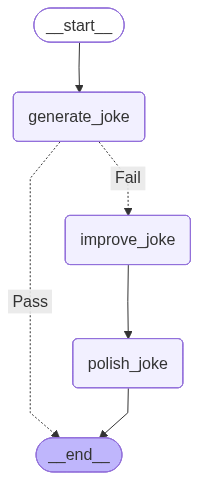

Initial joke:
Why did the cat sit on the computer? 

Because it wanted to keep an eye on the mouse! 

---

Would you like another joke? 😊

--- --- ---

Improved joke:
Okay, let's inject some wordplay and a little bit of humor! Here are a few options, building on your original and aiming for a chuckle:

**Option 1 (A little cheeky):**

Why did the cat sit on the computer? 

Because it heard there were a lot of pixels! 

**Option 2 (Focusing on the cat's perspective):**

Why did the cat sit on the computer? 

It needed to analyze the data stream! 

**Option 3 (A bit silly and unexpected):**

Why did the cat sit on the computer? 

It was feeling *purr-fessional* about the mouse! 

---

**Which one do you like best, or would you like me to try another approach?** 😊

--- --- ---

Final joke:
I really like **Option 3: It was feeling *purr-fessional* about the mouse!** – it's the most amusing and unexpected. It creates a wonderfully silly image and the pun is great!

Let's go with that! 😊

Wo

In [301]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="gemma3:1b")

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "??" in state["joke"] or "!!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

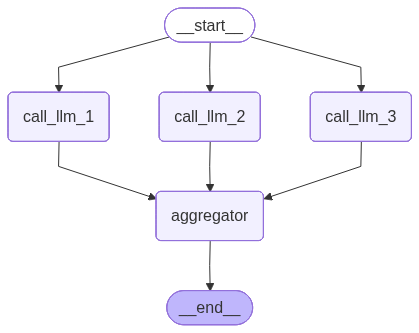

Here's a story, joke, and poem about cats!

STORY:
Okay, here's a story about cats, aiming for a slightly melancholic and observant tone. It's longer, but hopefully captures the feeling you're looking for.

---

The rain in Greyhaven always smelled of old books and damp earth. It seeped into the cobblestones, softening the edges of the antique shops and clinging to the threadbare edges of the doorways. And it always smelled of cats.

Silas was a grey tabby, older than most of the neighborhood cats. His fur was the color of a storm cloud, and his eyes, a deep, knowing amber, held a quiet sadness. He’d spent the last fifteen years observing Greyhaven, a tiny, crumbling town nestled between a brooding forest and a restless sea. He’d seen empires rise and fall in the houses, felt the tremors of loss in the empty rooms, and absorbed the slow, inevitable rhythm of the rain.

He lived with Mrs. Hawthorne, a woman who smelled of lavender and dust. She’d inherited the house and the cats – a mot

In [302]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [339]:
# CUSTOMER SUPPORT WORKFLOW

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [306]:
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [315]:
from langchain_ollama import ChatOllama
#llm = ChatOllama(model="gemma3:1b")
llm = ChatOllama(model="llama3.1:8b")

In [330]:
from datetime import datetime
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

In [317]:
TavilySearchResults().invoke("What is the baggage allowance for SWISS economy class?")

[{'title': 'Swiss Airlines Baggage Allowance Policy - CabinZero',
  'url': 'https://www.cabinzero.com/blogs/air-travel-tips/swiss-airlines-baggage-allowance-guide?srsltid=AfmBOorKgiPwF7wF3l-mH53olx9C4CT_l2__Z_A-tF92MzMNiuX8l-y3',
  'content': 'As the newest rule, SWISS Economy passengers are allowed one checked bag of up to 51 lbs / 23 kg (note: Light fares do not include free baggage allowance). SWISS Business passengers can check two bags of up to 70 lbs / 32 kg each. SWISS First passengers are allowed three bags of up to 70 lbs / 32 kg each.\n\n### 4. How much luggage is allowed on the SWISS premium economy? [...] Swiss Airlines Baggage Allowance Policy - CabinZero\n\nSWISS airlines cabin and underseat bag size and weight.\n\nOnly one free personal item will be allowed for Economy Class travellers. However, First and Business Class passengers are allowed two pieces of carry-on baggage weighing no more than 18 lbs / 8 kg and with physical dimensions greater than 22 x 16 x 9 in / 55 x

In [331]:
access_tools = [
    #TavilySearchResults(max_results=1),
    lookup_policy, 
    fetch_user_flight_information,
    search_flights,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

In [332]:

assistant_runnable = primary_assistant_prompt | llm.bind_tools(access_tools) 

In [273]:
# from langgraph.checkpoint.memory import InMemorySaver

# builder = StateGraph(State)
# builder.add_node("assistant", Assistant(assistant_runnable))


# builder.add_edge(START, "assistant")

# builder.add_edge("assistant", END)

# memory = InMemorySaver()

# graph = builder.compile(checkpointer=memory)



In [280]:
# from langgraph.prebuilt import ToolNode

# # Create a tool node for execution
# tool_node = ToolNode(access_tools)

# builder = StateGraph(State)
# builder.add_node("assistant", Assistant(assistant_runnable))
# builder.add_node("tools", tool_node)

# builder.add_edge(START, "assistant")
# builder.add_edge("assistant", "tools")
# builder.add_edge("tools", "assistant")
# builder.add_edge("assistant", END)

# graph = builder.compile()

In [333]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END

tool_node = ToolNode(access_tools)

builder = StateGraph(State)
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", tool_node)

# Start with assistant
builder.add_edge(START, "assistant")

# If assistant calls a tool, go to tools, else END
def route_assistant_output(state):
    last_message = state["messages"][-1]
    if last_message.tool_calls:  # assistant decided to use a tool
        return "tools"
    return END  # assistant gave final answer

builder.add_conditional_edges("assistant", route_assistant_output)

# Always return from tools back to assistant
builder.add_edge("tools", "assistant")

graph = builder.compile()


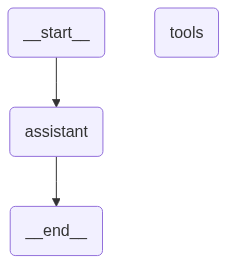

In [334]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [335]:
db

'travel2.sqlite'

In [336]:
db = update_dates(db)
thread_id = "customer-support-001"
config = {
    "configurable": {
        "passenger_id": "8149 604011",
        "thread_id": thread_id,
        "db":db
    }
}


In [337]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [340]:
_printed = set()
from langchain_core.messages import HumanMessage

def chat_query(question):
    #question = "what is baggage policy?"
    #events = graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    events = graph.stream(
          {"messages": [HumanMessage(content=question)]},config,stream_mode="values")
    for event in events:
        print(event)
        _print_event(event, _printed)

while True:
    query = input("Enter your question (or 'exit' to quit): ")
    if query.lower() == 'exit':
        break
    chat_query(query)

KeyError: 'messages'

In [ ]:
config

{'configurable': {'passenger_id': '8149 604011',
  'thread_id': 'customer-support-001'}}

In [ ]:
### Iteration 2

In [326]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [327]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(access_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = InMemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

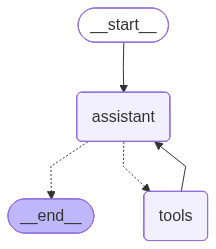

In [328]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [295]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (3365e79f-67ef-4c13-8849-ee4066d8a1fb)
 Call ID: 3365e79f-67ef-4c13-8849-ee4066d8a1fb
  Args:
Function called!
DB Connected
================================= Tool Message =================================
Name: fetch_user_flight_information

[{'passenger_id': '3442 587242', 'ticket_no': '7240005432906569', 'flight_no': 'LX0002', 'scheduled_departure': '2025-09-23 05:05:27.880251-04:00', 'scheduled_arrival': '2025-09-23 06:35:27.880251-04:00', 'departure_airport': 'BSL', 'arrival_airport': 'CDG', 'status': 'Scheduled', 'aircraft_code': 'SU9', 'fare_conditions': 'Economy', 'amount': 12100, 'actual_departure': None, 'actual_arrival': None, 'boarding_no': None, 'seat_no': None}, {'passenger_id': '3442 587242', 'ticket_no': '7240005432906569', 'flight_no

In [329]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

KeyError: 'messages'